# Лабораторна Робота № 7
## Передавальне навчання з великими мовними моделями


## Мета: набути навички використання та донавчання великих мовних моделей на базі сервісу HuggingFace для розв'язання NLP задач.

### Імпорт бібліотек та датасету

In [1]:
!pip install datasets
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 31.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-no

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_metric
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

In [3]:
df_train = pd.read_csv("lab06_train.txt", sep=";", header=None, names=['Text', 'Emotion'])
df_test = pd.read_csv("lab06_test.txt", sep=";", header=None, names=['Text', 'Emotion'])
df_val = pd.read_csv("lab06_val.txt", sep=";", header=None, names=['Text', 'Emotion'])

In [4]:
emotions = df_train['Emotion'].unique().tolist()
label_encoder = LabelEncoder()
label_encoder.fit(emotions)
num_labels = len(emotions)

In [5]:
df_train['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

### Завантаження моделі, токенизатора та токенизація даних

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.encodings = tokenizer(dataframe['Text'].tolist(), truncation=True, padding=True, max_length=512)
        self.labels = label_encoder.transform(dataframe['Emotion'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [8]:
train_dataset = EmotionDataset(df_train, tokenizer)
val_dataset = EmotionDataset(df_val, tokenizer)
test_dataset = EmotionDataset(df_test, tokenizer)


In [9]:
emotions

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

In [10]:
df_train[:15]

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


In [11]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


<ipython-input-12-c203b637589b>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [13]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [15]:
import torch
import numpy as np

trainer.train()

# Evaluation
results = trainer.evaluate()

print("Evaluation results:", results)

# Save the model
model_path = "bert-emotion-classifier"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.237400,0.199211,0.926000
2,0.113800,0.131883,0.941000
3,0.083400,0.133978,0.941000


Evaluation results: {'eval_loss': 0.1339775025844574, 'eval_accuracy': 0.941, 'eval_runtime': 8.2842, 'eval_samples_per_second': 241.424, 'eval_steps_per_second': 3.863, 'epoch': 3.0}


('bert-emotion-classifier/tokenizer_config.json',
 'bert-emotion-classifier/special_tokens_map.json',
 'bert-emotion-classifier/vocab.txt',
 'bert-emotion-classifier/added_tokens.json')

In [16]:
predictions = trainer.predict(test_dataset)
print("Test Accuracy:", predictions.metrics['test_accuracy'])

Test Accuracy: 0.931


In [17]:
predictions

PredictionOutput(predictions=array([[-1.2614207 , -2.0366137 , -0.20321824, -1.1212796 ,  6.590207  ,
        -1.6204541 ],
       [-1.0803078 , -1.4615399 , -1.0079452 , -1.1815478 ,  6.8878355 ,
        -1.734354  ],
       [-1.0222496 , -1.6024165 , -1.4425408 , -0.9319704 ,  6.984379  ,
        -1.4344039 ],
       ...,
       [-1.8405741 , -1.8268714 ,  6.870476  , -1.6949806 , -1.679972  ,
        -1.0308702 ],
       [-1.8884232 , -1.4279292 ,  6.8319063 , -1.6708982 , -1.6830913 ,
        -1.2820677 ],
       [-1.5896522 ,  4.0308714 , -1.8303767 , -2.069005  , -1.0323328 ,
         3.4498916 ]], dtype=float32), label_ids=array([4, 4, 4, ..., 2, 2, 1]), metrics={'test_loss': 0.14278152585029602, 'test_accuracy': 0.931, 'test_runtime': 7.2587, 'test_samples_per_second': 275.531, 'test_steps_per_second': 4.408})

In [18]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=emotions, yticklabels=emotions)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()


Classification Report:
              precision    recall  f1-score   support

       anger       0.90      0.92      0.91       275
        fear       0.87      0.94      0.91       224
         joy       0.94      0.98      0.96       695
        love       0.93      0.76      0.84       159
     sadness       0.97      0.96      0.96       581
    surprise       0.86      0.65      0.74        66

    accuracy                           0.93      2000
   macro avg       0.91      0.87      0.89      2000
weighted avg       0.93      0.93      0.93      2000



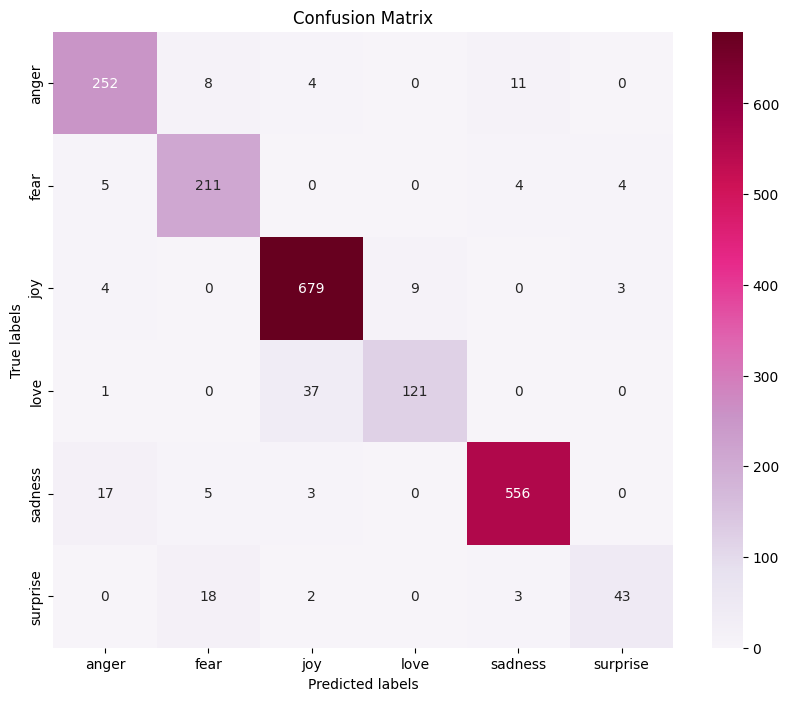

In [19]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
pred_logits = predictions.predictions
y_pred = np.argmax(pred_logits, axis=1)
y_test = predictions.label_ids


print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(range(num_labels))))


def plot_confusion_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(y_test, y_pred, label_encoder.inverse_transform(range(num_labels)))